In [1]:
# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Loading some sklearn packaces for modelling.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Some packages for word clouds and NER.
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
import spacy
import en_core_web_sm

# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime
from tqdm import tqdm

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.
import torch
from torchtext import data
# from torchtext.legacy import data
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 3407
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class="anchor" id="top" style=" margin-right: auto; margin-left: auto; padding: 10px; font-size : 15px; background-color: #DFFFFE; border-radius: 2px; font-color :  #581845  ; border: 2px solid #581845;"> Natural Language Processing with Disaster Tweets: Predict which Tweets are about real disasters and which ones are not <b>This is a typical text classification problem.</b>

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 15px;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
 
- [1. Dataset Description](#1)
- [2. Cleaning Text](#2)
- [3. Exploratory Data Analysis](#3)
    - [3.1 Target Distribution](#3.1)
    - [3.2 Word Count Distribution](#3.2)
    - [3.3 Most Common Ngrams](#33-most-common-ngrams)
    - [3.4 Determining Topics](#34-determining-topics)
    - [3.5 Word Cloud](#35-word-cloud)
    - [3.6 Named Entity Recognition](#36-named-entity-recognition)
- [4. DModel Architecture](#4)
    - [4.1 Create Dataset](#4.1)
    - [4.2 LSTM Model](#4.2)
- [5. Results and Analysis](#5)
- [6. Conclusion](#6)
- [7. Extra: BERT](#7)

# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Dataset Description </p>   </span></font></center> 

# 1. Dataset Description

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
    
Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

Columns
- `id` - a unique identifier for each tweet
- `text` - the text of the tweet
- `location` - the location the tweet was sent from (may be blank)
- `keyword` - a particular keyword from the tweet (may be blank)
- `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

Data Source By:
- Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

In [2]:
# Loading the train and test data for visualization & exploration.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Taking general look at the both datasets.
display(train.sample(5))
display(test.sample(5))

,id,keyword,location,text,target
4600,6542,injury,"Houston, TX",@NEPD_Loyko Texans hope you are wrong. Radio i...,0
6276,8967,storm,"Wilmington, NC",New item: Pillow Covers ANY SIZE Pillow Cover ...,0
1215,1753,buildings%20burning,somewhere over a rainbow,@DoctorFluxx @StefanEJones @spinnellii @themer...,1
4958,7068,meltdown,IL,@crowdtappers @joinvroom OMG I remember the me...,0
539,784,avalanche,Buy Give Me My Money,I HAVE GOT MORE VIDEOS THAN YOU RAPPERS GOT SO...,0


,id,keyword,location,text
1004,3313,demolished,HTX iNNeRvErSe,#BananaLivesMatter ... but not more than #Hote...
1029,3375,demolition,"Indianapolis, IN",Buzzing: Billy Joel Brings Down the House for ...
2175,7276,nuclear%20disaster,Brussels,Fukushima Watch - Fukushima Watch Nuclear Disa...
2532,8456,screamed,NaN,I'm having a meltdown because of Game of Thron...
1467,4865,explode,~always in motion~,Vanessa was about to explode! This is what she...


In [4]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


# <a id="2"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Cleaning Text </p>   </span></font></center>
# 2. Cleaning Text
Before we visualize our text data I wanted to make it look better with some general helper functions to clear out things like: urls, emojis, html tags, punctuations... When we have cleaner text we can apply our tokenizer to split each word into a token. We'll apply this and next steps to individual columns to show each step of our progress. Next we transforming all words to lowercase then we remove stopwords (they don't mean much in sentence alone) so we use NLTK stopwords for it.
After removing these words we gonna lemmatize them but for that we need to add some extra steps to do it properly: We gonna apply part of speech tags to our text (like verb, noun etc.) then we convert them to wordnet format and finally we can apply lemmatizer and save it to 'lemmatized' column. And one last thing we convert these tokenized lists back to str version for future uses.
So basically what we did are:
- Removed urls, emojis, html tags and punctuations,
- Tokenized the tweet base texts,
- Lower cased clean text,
- Removed stopwords,
- Applied part of speech tags,
- Converted part of speeches to wordnet format,
- Applying word lemmatizer,
- Converted tokenized text to string again.


In [5]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
train['text_clean'] = train['text'].apply(lambda x: remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: remove_punct(x))

In [6]:
# Tokenizing the tweet base texts.
train['tokenized'] = train['text_clean'].apply(word_tokenize)
train.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [7]:
# Lower casing clean text.
train['tokenized'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x])
train.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


In [8]:
# Removing stopwords.
train['stopwords_removed'] = train['tokenized'].apply(
    lambda x: [word for word in x if word not in stop])
train.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [9]:
# Applying part of speech tags.
train['pos_tags'] = train['stopwords_removed'].apply(nltk.tag.pos_tag)
train.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [10]:
# Converting part of speeches to wordnet format.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
train.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [11]:
# Applying word lemmatizer.
wnl = WordNetLemmatizer()
train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]
train.head()

,id,keyword,location,text,target,text_clean,tokenized,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


In [12]:
def fill_no_meaning(x):
    if len(x) == 0:
        return 'like youtube video'
    else:
        return x

train['lemma_str'] = train['lemma_str'].apply(lambda x: fill_no_meaning(x))

In [13]:
def preprocess_data(df):
    # Applying helper functions
    df['text_clean'] = df['text'].apply(lambda x: remove_URL(x))
    df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
    df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
    df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))
    df['tokenized'] = df['text_clean'].apply(word_tokenize)
    df['tokenized'] = df['tokenized'].apply(
        lambda x: [word.lower() for word in x])
    df['stopwords_removed'] = df['tokenized'].apply(
        lambda x: [word for word in x if word not in stop])
    df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)
    df['wordnet_pos'] = df['pos_tags'].apply(
        lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['wordnet_pos'].apply(
        lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = df['lemmatized'].apply(
        lambda x: [word for word in x if word not in stop])
    df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]
    df['lemma_str'] = df['lemma_str'].apply(lambda x: fill_no_meaning(x))
    return df

test = preprocess_data(test)

 # <a id="3"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Exploratory Data Analysis </p>   </span></font></center>
# 3. Exploratory Data Analysis

## 3.1 Target Distribution
# <a id="3.1"></a>

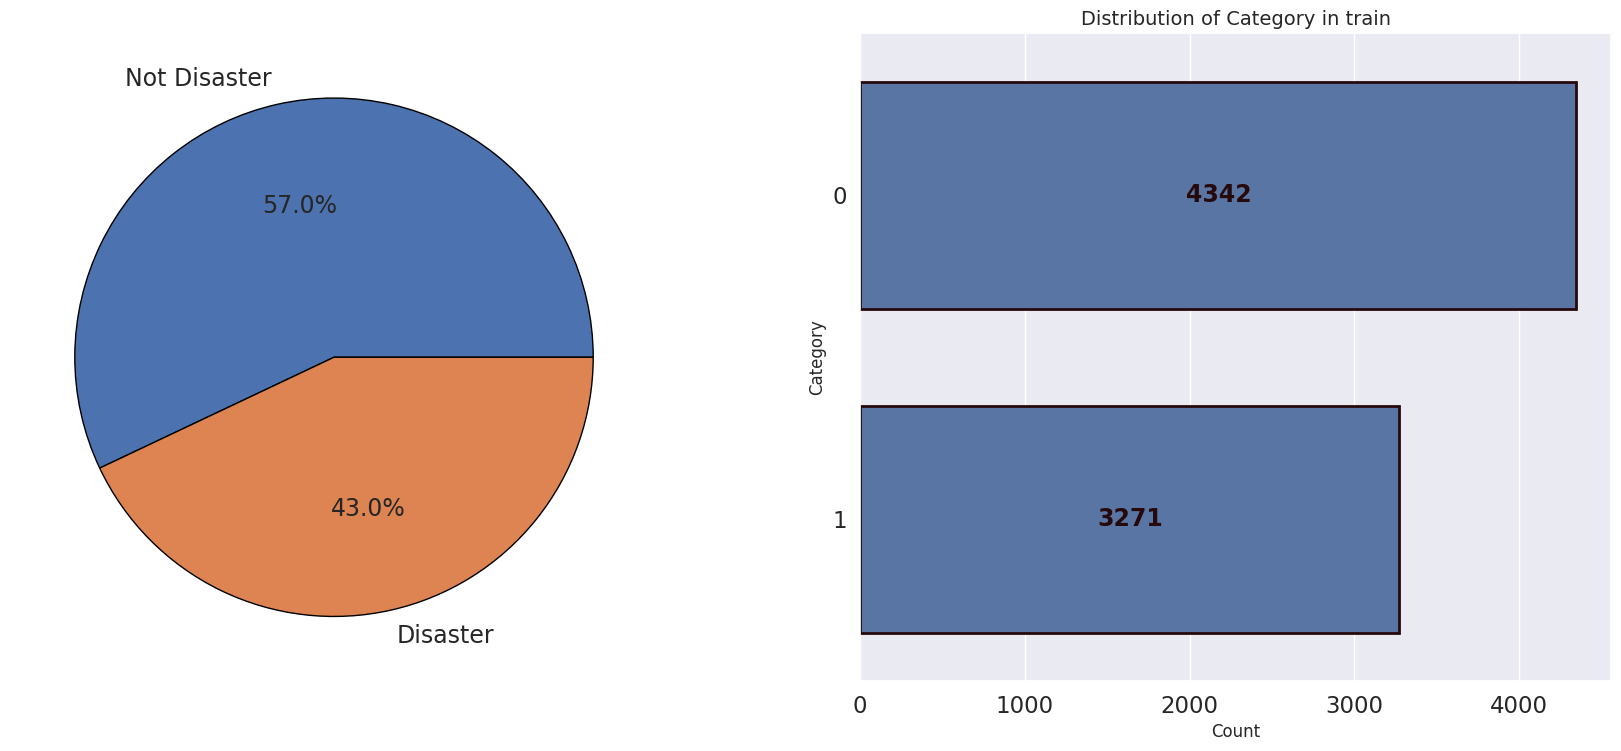

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(19,8))

wedges = ax[0].pie(autopct='%1.1f%%', x=train['target'].value_counts(), labels=['Not Disaster', 'Disaster'])
p = sns.countplot(y="target", data=train, edgecolor='#26090b', linewidth=2, width=0.7)
wedges[2][0].set_fontsize(17)
wedges[2][1].set_fontsize(17)
wedges[0][0].set_edgecolor('black')
wedges[0][1].set_edgecolor('black')
wedges[1][0].set_fontsize(17)
wedges[1][1].set_fontsize(17)

for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),)
    
plt.title("Distribution of Category in train", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.savefig('figures/target_distribution.svg')
plt.show()

## 3.2 Word Count Distribution
# <a id="3.2"></a>

In [15]:
# Creating a new feature for the visualization.
train['Character Count'] = train['lemma_str'].apply(lambda x: len(str(x)))

def plot_dist(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')
    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

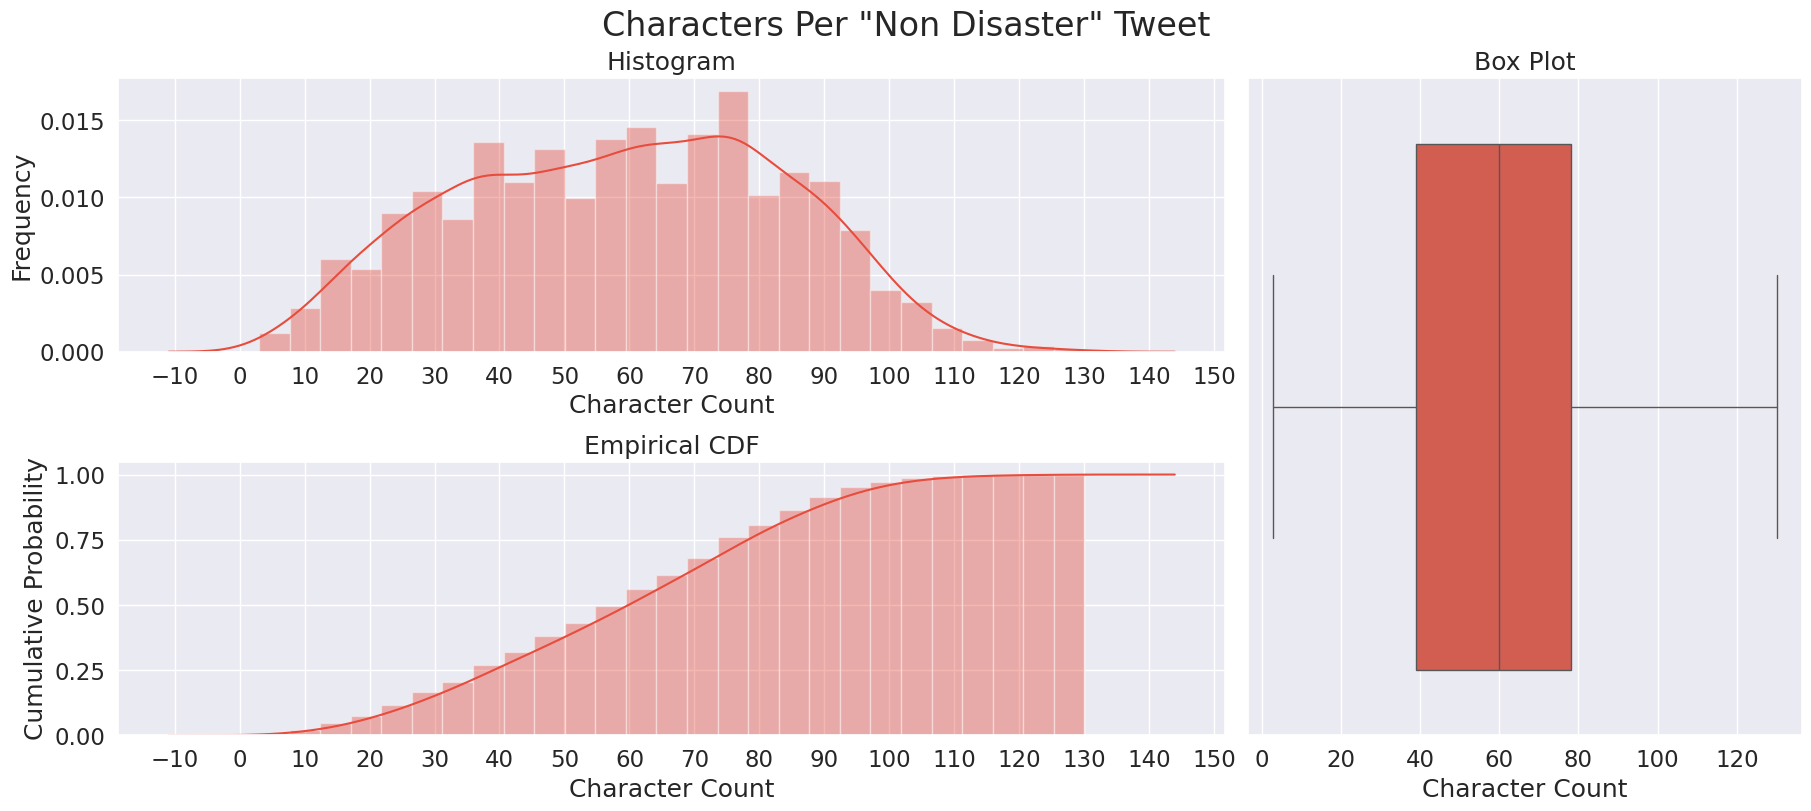

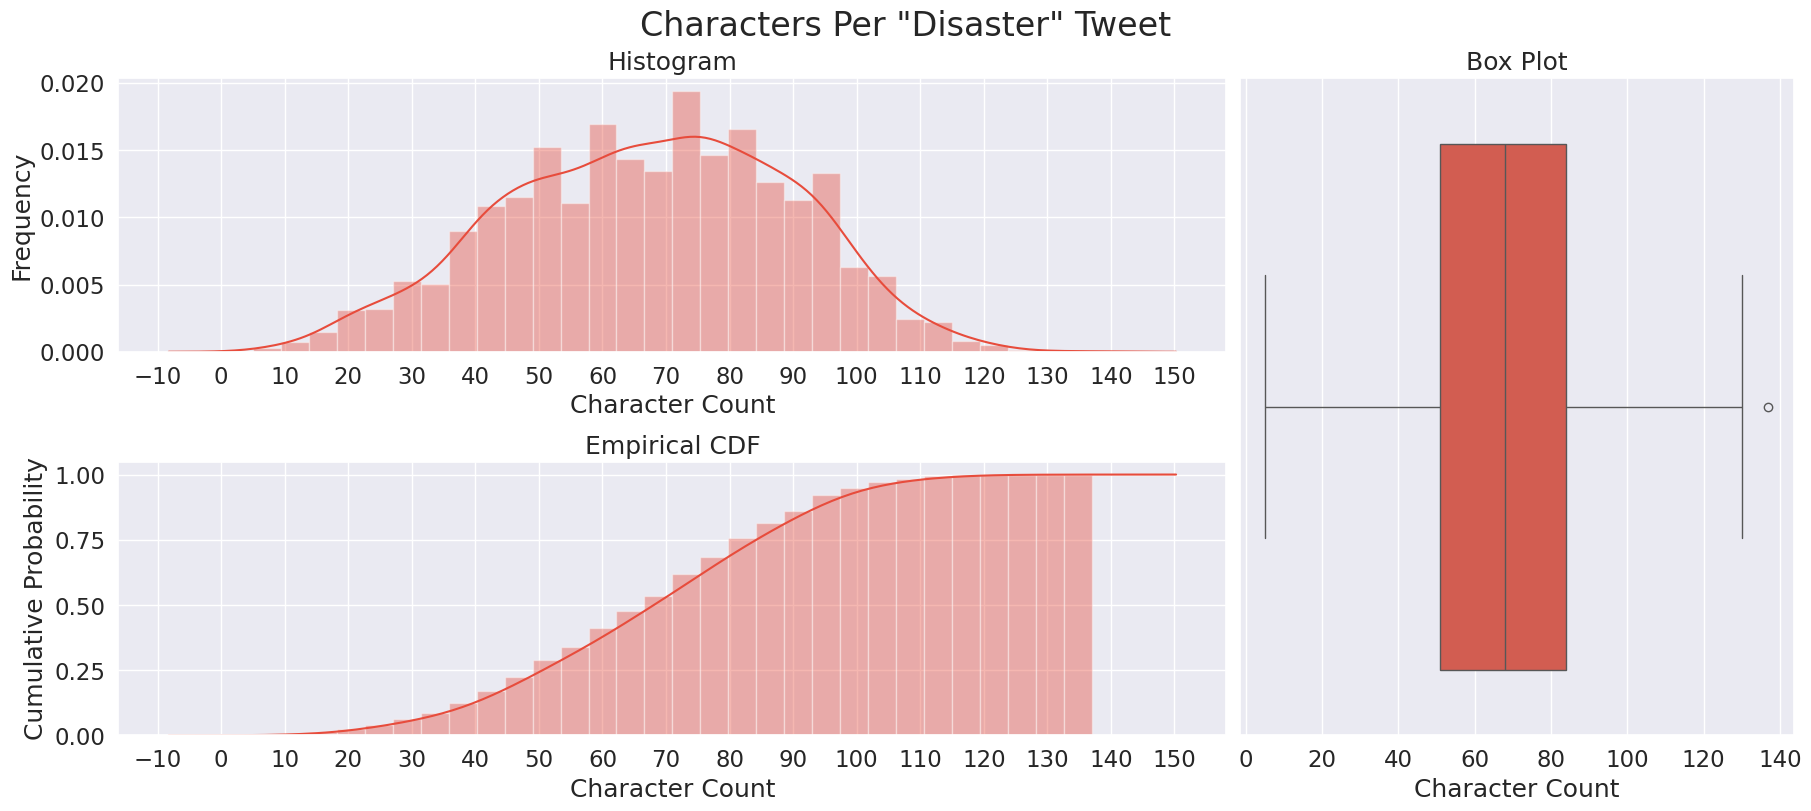

In [16]:
plot_dist(train[train['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

plot_dist(train[train['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

In [17]:
lis = [
    train[train['target'] == 0]['lemma_str'],
    train[train['target'] == 1]['lemma_str']
]

## 3.3 Most Common Ngrams
# <a id="3.3"></a>

In [18]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:30]

        top_n_bigrams = _get_top_ngram(i, n)
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

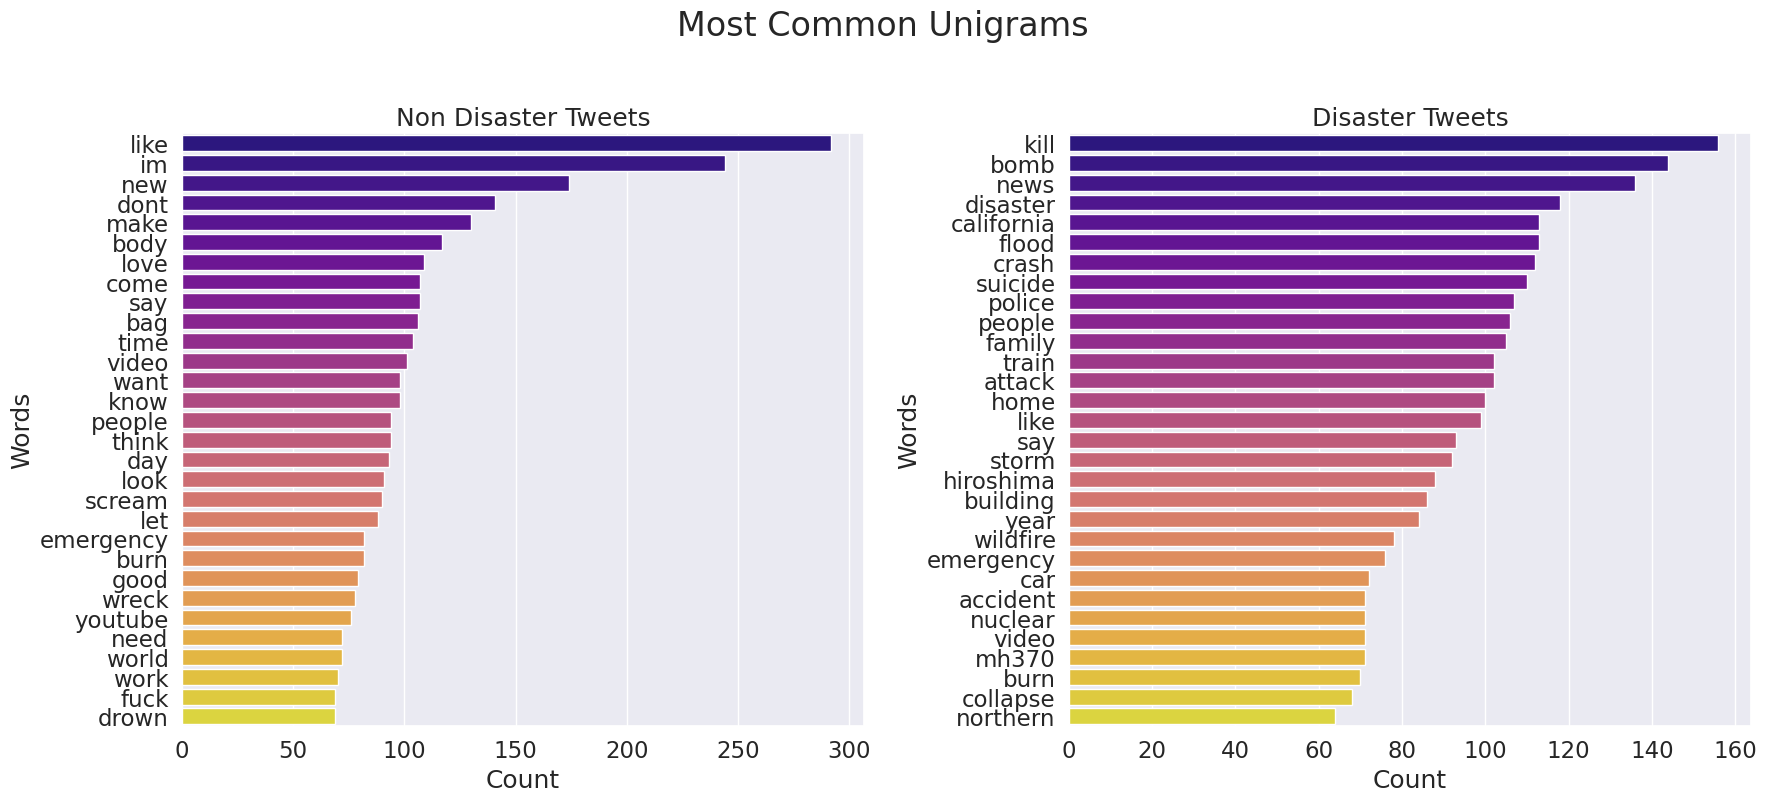

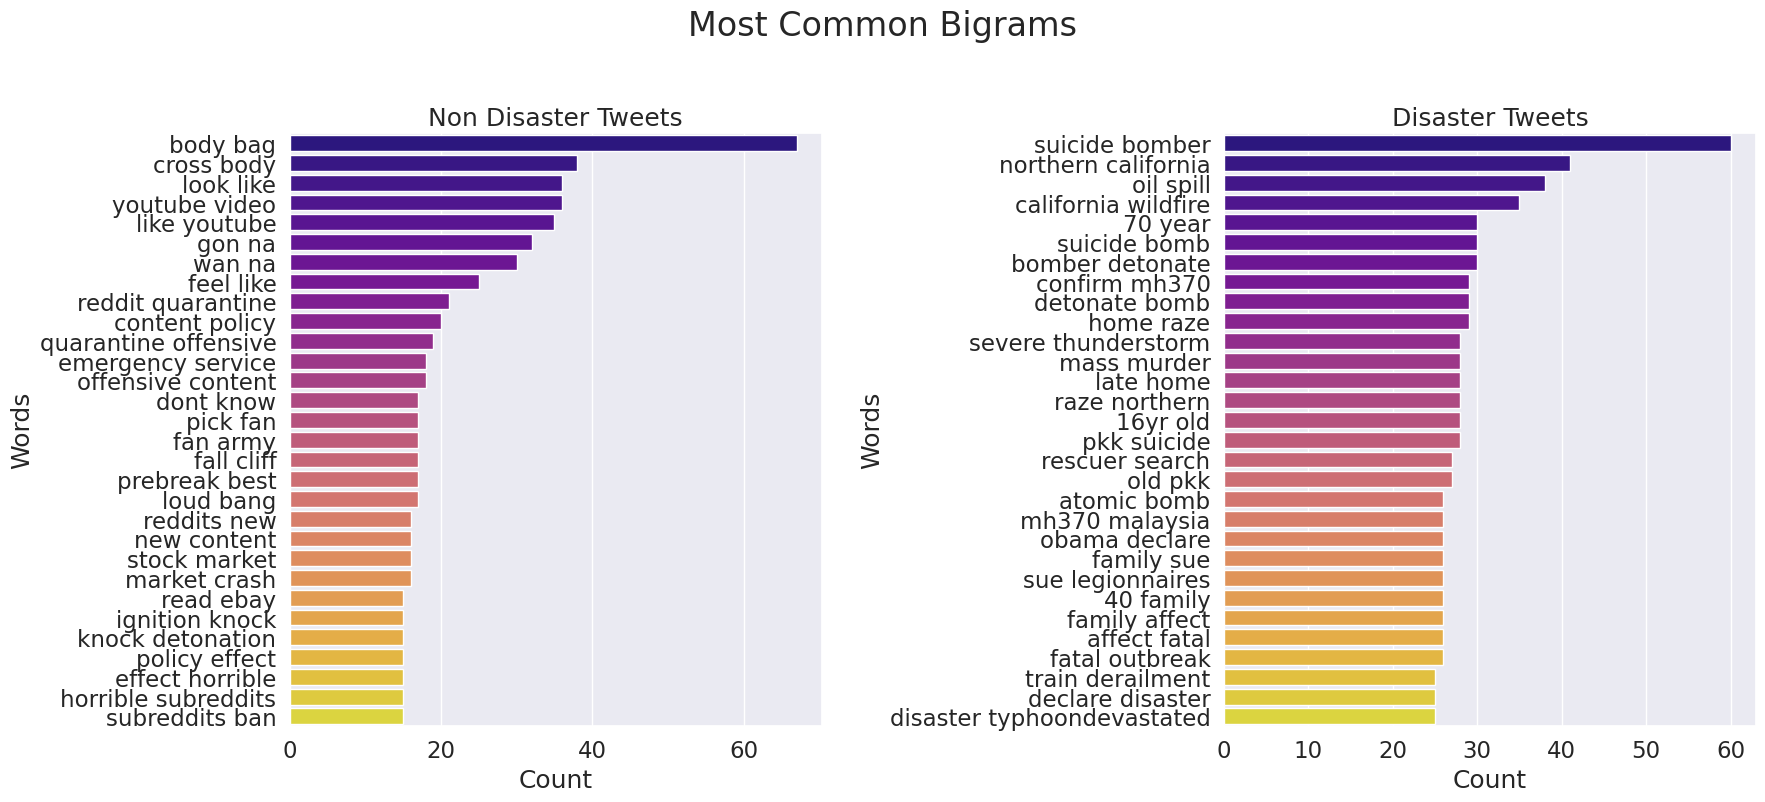

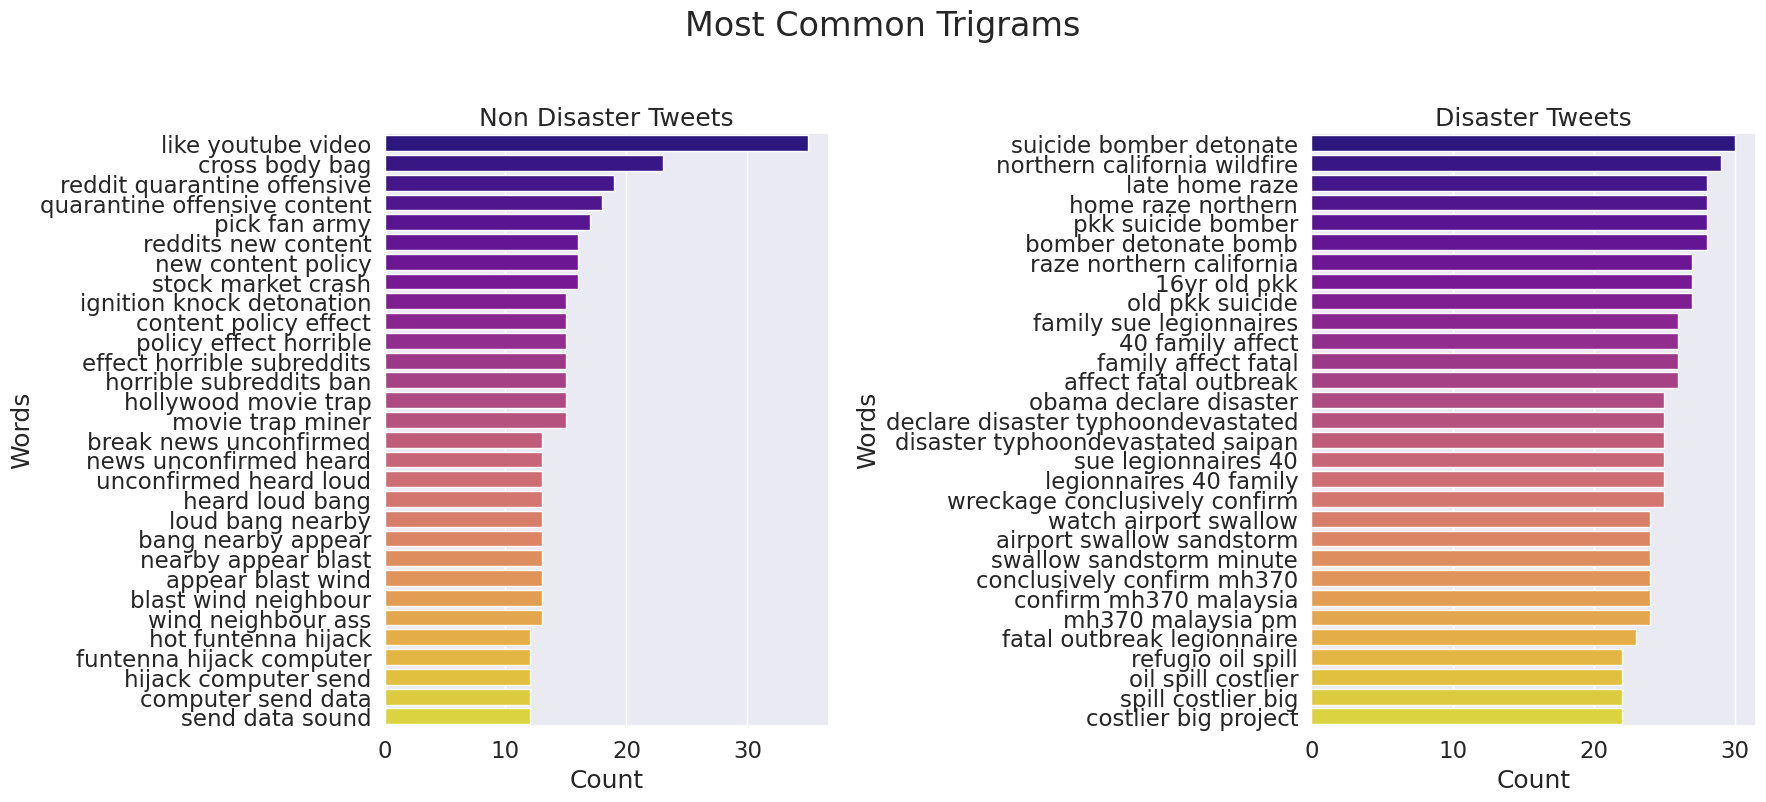

In [19]:
ngrams(1, 'Most Common Unigrams')
ngrams(2, 'Most Common Bigrams')
ngrams(3, 'Most Common Trigrams')

## 3.4 Determining Topics
# <a id="3.4"></a>

In [20]:
def display_topics(text, no_top_words, topic):
    """ A function for determining the topics present in our corpus with nmf """
    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=no_top_words, random_state=0, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [21]:
display_topics(lis[0], 10, 'Non Disaster Topics\n')

Non Disaster Topics

Topic 1:
get lol blow good bomb first day demolish someone play
Topic 2:
like video youtube look feel back fire fatality sink mudslide
Topic 3:
im traumatise still disaster na gon attack drown dead weapon
Topic 4:
new emergency full read content post quarantine many storm re
Topic 5:
body bag cross shoulder woman full lady read ebay really
Topic 6:
dont one see know come say make want think fire
Topic 7:
scream fuck phone face good song loud hit baby time
Topic 8:
via youtube god change obliteration news story stop service military
Topic 9:
go content quarantine many explode make reddit let top deluge
Topic 10:
love crush collide woman much death military armageddon would check


In [22]:
display_topics(lis[1], 10, 'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest building truck evacuate wild burn service california set
Topic 2:
suicide bomb kill bomber saudi mosque detonate pkk old 16yr
Topic 3:
california wildfire home northern late news raze abc collapse burn
Topic 4:
flood storm rain people train issue severe weather rescue violent
Topic 5:
hiroshima atomic bomb year japan still anniversary 70 war bombing
Topic 6:
via attack wave israeli police evacuation heat post wound car
Topic 7:
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 8:
disaster nuclear obama natural declare typhoondevastated saipan sign collapse northern
Topic 9:
crash kill accident helicopter air train fear say police car
Topic 10:
get watch minute sandstorm swallow airport go im like dont


## 3.5 Word Cloud
# <a id="3.5"></a>


In [23]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords.extend(wordlist)

    allwords = ' '.join(allwords)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        contour_width=0.1,
        contour_color='grey',
    ).generate(allwords)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

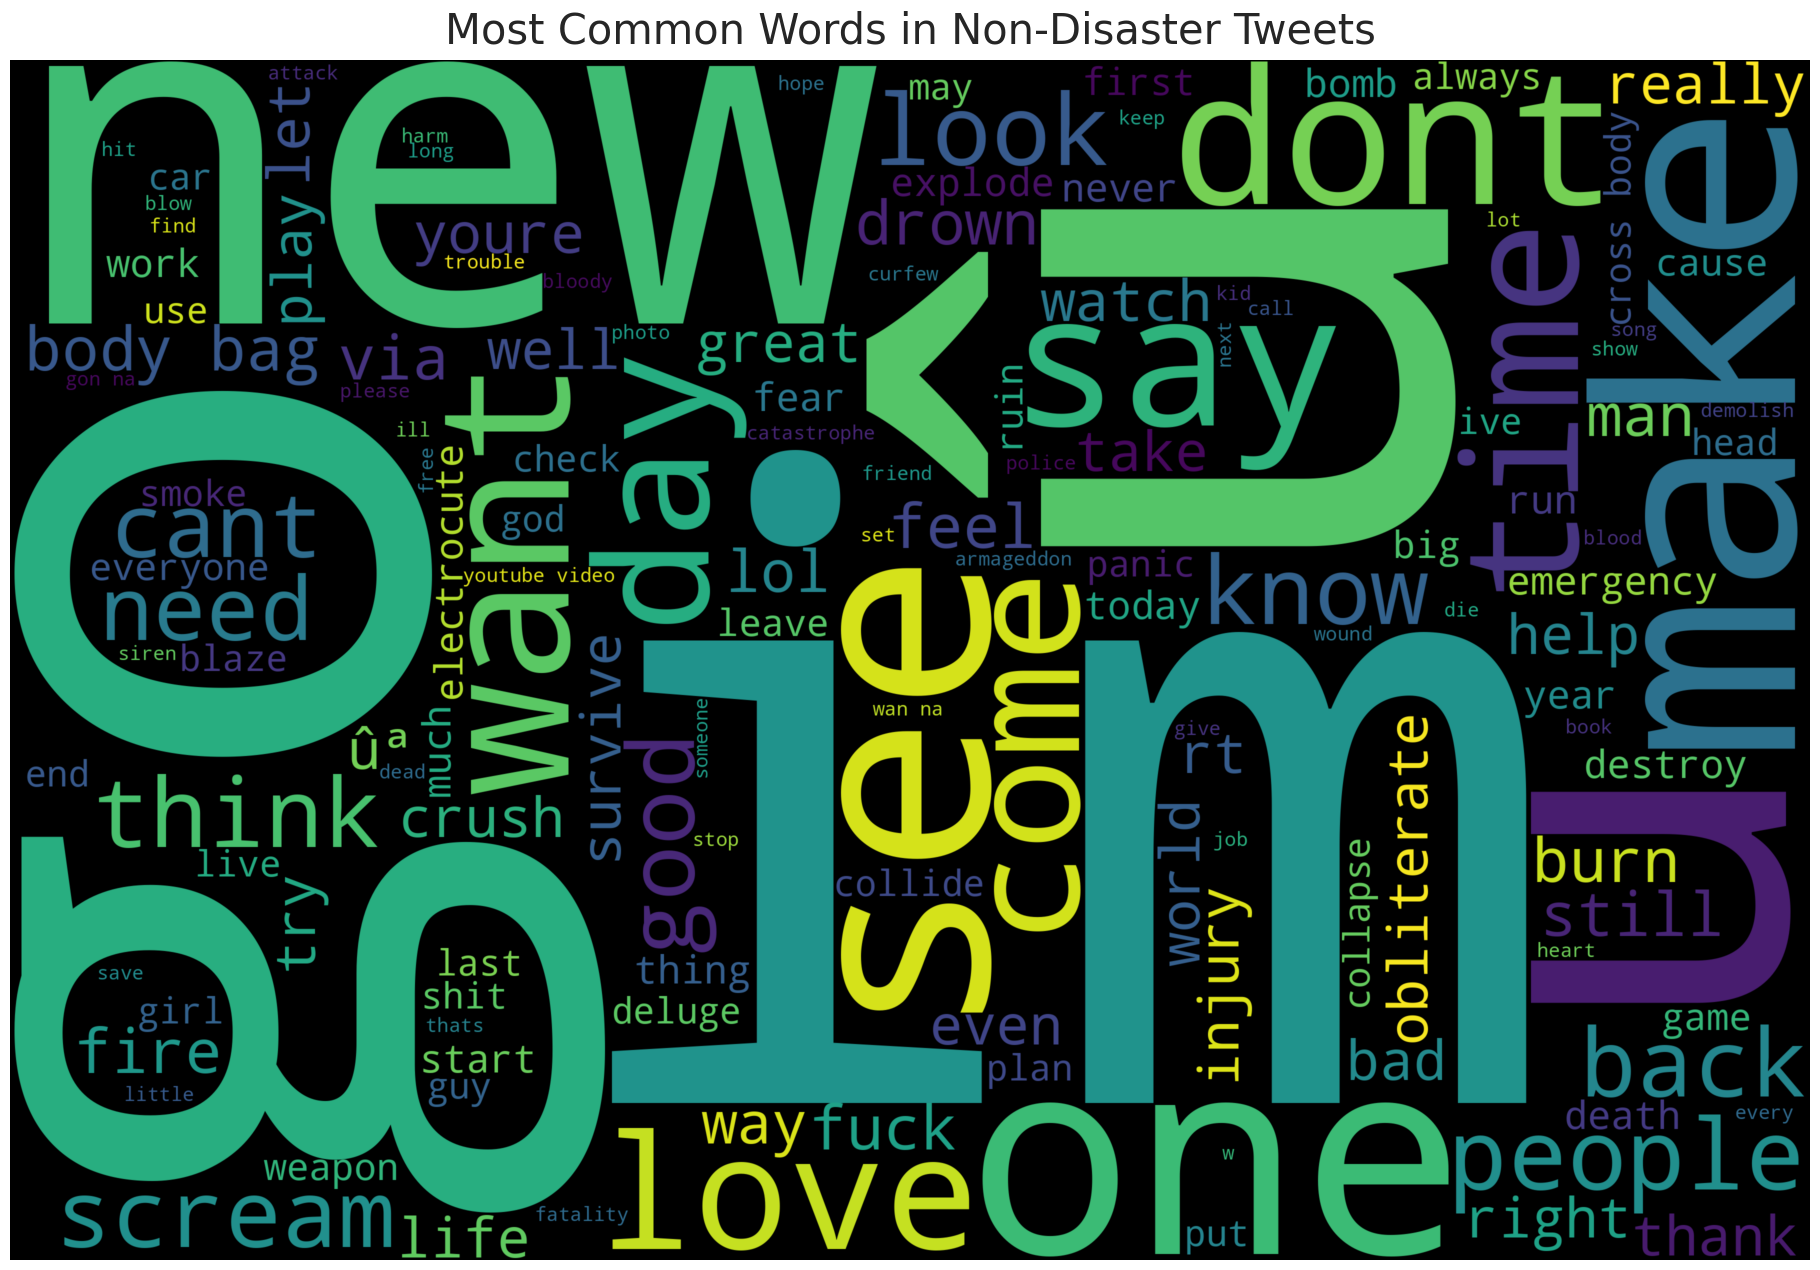

In [24]:
plot_wordcloud(train[train['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

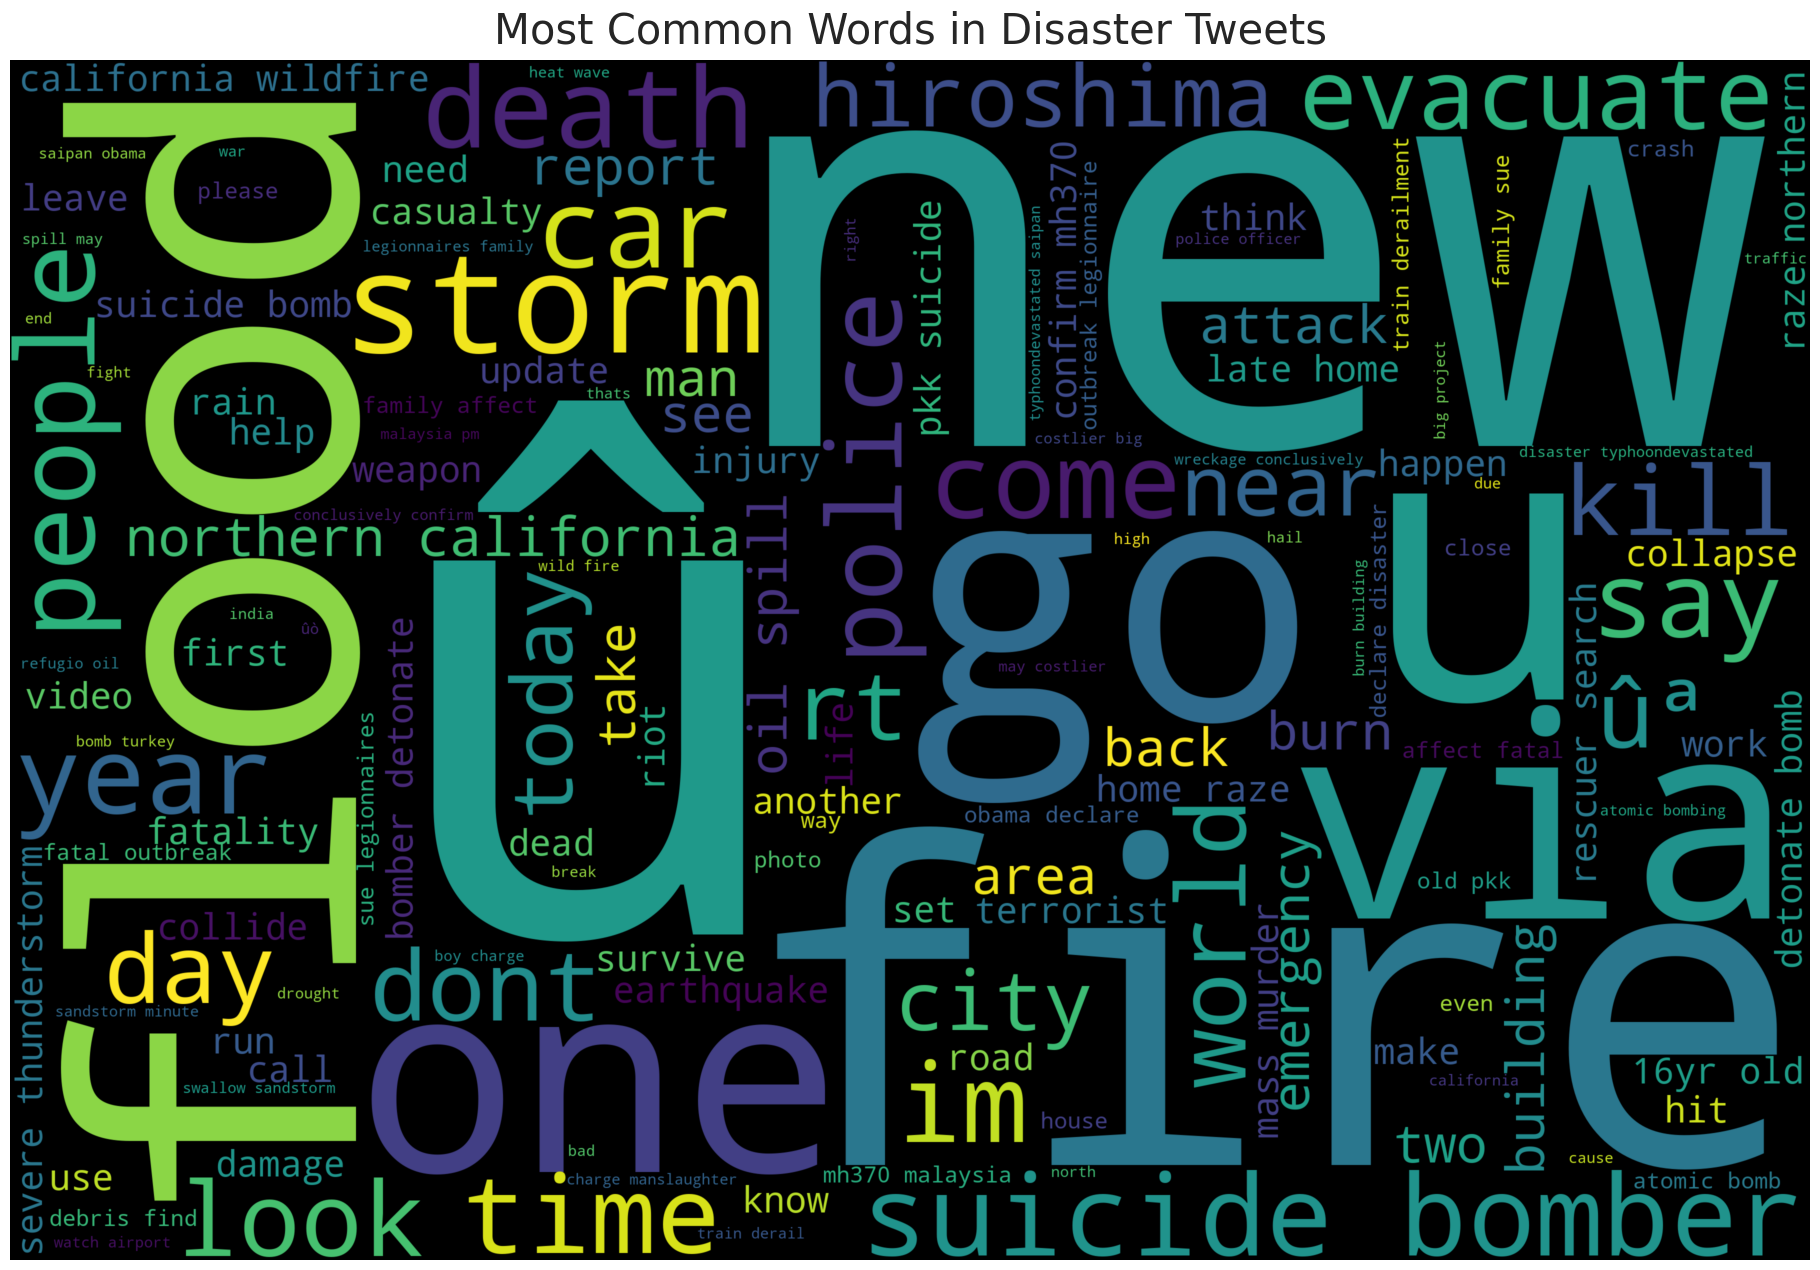

In [25]:
plot_wordcloud(train[train['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)

## 3.6 Named Entity Recognition

In [26]:
# Loading NER.
nlp = en_core_web_sm.load()

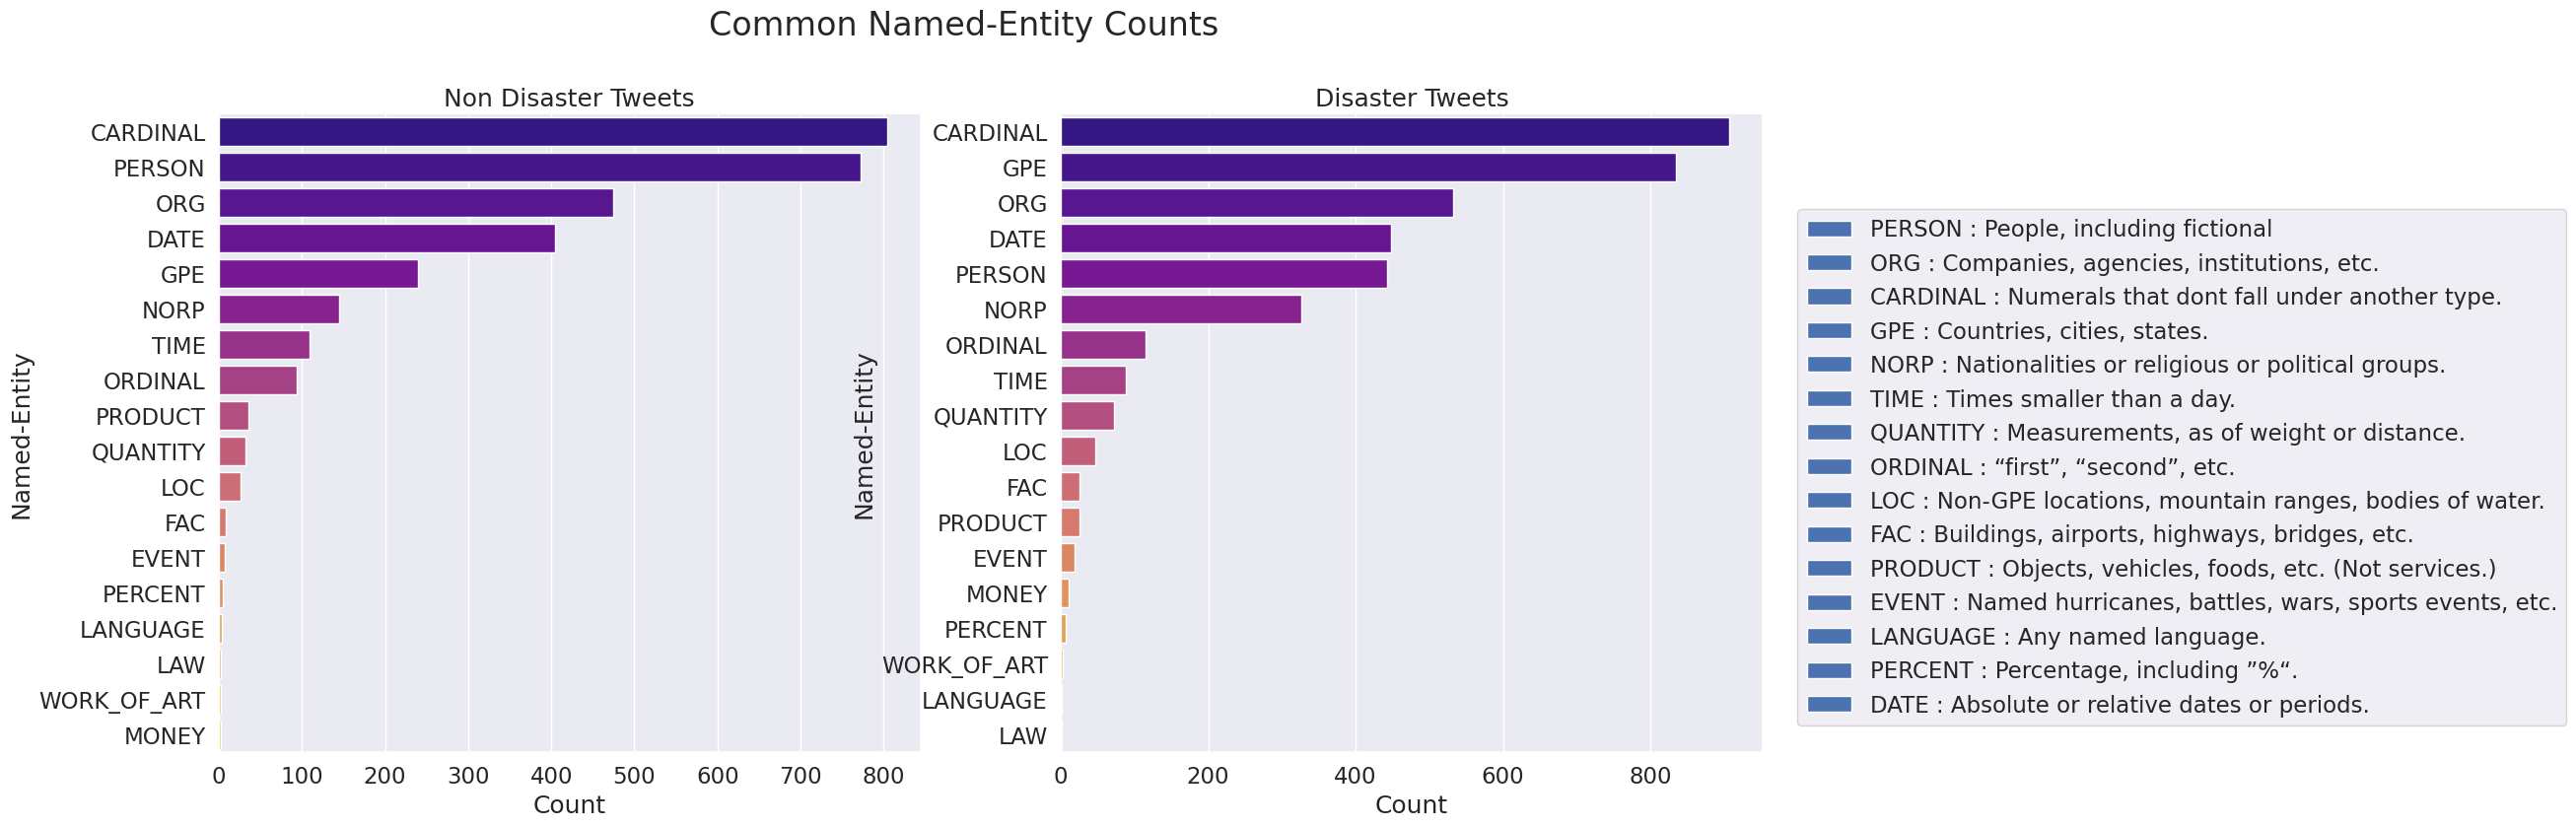

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:30]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')

patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15,], bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)
plt.savefig('figures/ner.svg')
plt.show()

# <a id="4"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">DModel Architecture </p>   </span></font></center>
# 4. DModel Architecture

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
def remove_space(x):
    return x.strip()

labels = train['target']
idx = len(labels)
train = train.fillna('')
test = test.fillna('')
train['lemma_str'] = (train['lemma_str'] + ' ' + train['location']).apply(lambda x: remove_space(x))
test['lemma_str'] = (test['lemma_str'] + ' ' + test['location']).apply(lambda x: remove_space(x))
train = train.lemma_str
test = test.lemma_str

## 4.1 Create Dataset

We need to create Field objects to process the text data. These field objects will contain information for converting the texts to Tensors. We will set two parameters:

- `tokenize=spacy`
- `include_arguments=True \`


Which implies that Spacy will be used to tokenize the texts and that the field objects should include length of the texts - which will be needed to pad the texts. We will later use methods of these objects to create a vocabulary, which will help us create a numerical representation for every token.


The `LabelField` is a shallow wrappper around field, useful for data labels.

In [30]:
train_X, valid_X, train_y, valid_y = train_test_split(train, labels, train_size=0.8, random_state=3407)
train_df = pd.concat([train_X, train_y], axis=1)
valid_df = pd.concat([valid_X, valid_y], axis=1)
test_df = pd.DataFrame(test)
test_df['target'] = 0

In [31]:
TEXT = data.Field(tokenize='spacy', include_lengths=True)
LABEL = data.LabelField(dtype = torch.long)

In [32]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target
            text = row.lemma_str
            examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [33]:
fields = [('text',TEXT), ('label',LABEL)]
train_ds, val_ds, test_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df, test_df=test_df)

We will build the vocabulary using only the training dataset. This can be accessed through TEXT.vocab and will be shared by the validation dataset.
We will use pretrainied 200 dimensional vectors to represent the tokens. Any unknown token will have a zero vector. These vectors will be later loaded as the embedding layer.

**Notations:**
We use the GloVe algorithm to obtain vector representations for words. In order to capture in a quantitative way the nuance necessary to distinguish man from woman, it is necessary for a model to associate more than a single number to the word pair. A natural and simple candidate for an enlarged set of discriminative numbers is the vector difference between the two word vectors. GloVe is designed in order that such vector differences capture as much as possible the meaning specified by the juxtaposition of two words.

In [34]:
MAX_VOCAB_SIZE = 30000

TEXT.build_vocab(train_ds,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_,
                 )

In [35]:
LABEL.build_vocab(train_ds)

In [36]:
batch_size = 8192

train_dataloader, validation_dataloader = data.BucketIterator.splits(
    (train_ds, val_ds),
    batch_size=batch_size,
    sort_within_batch=True,
    device=device)

test_dataloader = data.BucketIterator(
    test_ds,
    batch_size=batch_size,
    sort_within_batch=False,
    device=device,
    shuffle=False
)

### 4.2 LSTM Model

The term “long short-term memory” comes from the following intuition. Simple recurrent neural networks have long-term memory in the form of weights. The weights change slowly during training, encoding general knowledge about the data. They also have short-term memory in the form of ephemeral activations, which pass from each node to successive nodes. The LSTM model introduces an intermediate type of storage via the memory cell. A memory cell is a composite unit, built from simpler nodes in a specific connectivity pattern, with the novel inclusion of multiplicative nodes.

LSTMs have three types of gates: input gates, forget gates, and output gates that control the flow of information. The hidden layer output of LSTM includes the hidden state and the memory cell internal state. Only the hidden state is passed into the output layer while the memory cell internal state remains entirely internal. LSTMs can alleviate vanishing and exploding gradients.


![lstm](figures/lstm.png)


In [37]:
class DisasterLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        if bidirectional:
            self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        else:
            self.fc1 = nn.Linear(hidden_dim, hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):
        # text = [sent len, batch size]
        embedded = self.embedding(text)
        text_lengths = text_lengths.detach().cpu()
        # embedded = [sent len, batch size, emb dim]
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        if self.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
        return output

In [38]:
# Hyperparameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  # padding

In [39]:
#creating instance of our LSTM_net class
model = DisasterLSTM(INPUT_DIM,
                     EMBEDDING_DIM,
                     HIDDEN_DIM,
                     OUTPUT_DIM,
                     N_LAYERS,
                     BIDIRECTIONAL,
                     DROPOUT,
                     PAD_IDX)
model.to(device) #CNN to GPU

DisasterLSTM(
  (embedding): Embedding(16560, 200, padding_idx=1)
  (rnn): LSTM(200, 256, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [40]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([16560, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1765,  0.2921, -0.0021,  ..., -0.2077, -0.2319, -0.1081],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [41]:
#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1765,  0.2921, -0.0021,  ..., -0.2077, -0.2319, -0.1081],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


In [42]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 80
learning_rate = 0.001
# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

In [43]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        text, text_lengths = batch.text
        model.zero_grad()

        logits = model(text, text_lengths)
        loss = criterion(logits, batch.label)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()

    # Tracking variables:
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    # Evaluate data for one epoch.
    for batch in validation_dataloader:
        text, text_lengths = batch.text

        with torch.no_grad():
            logits = model(text, text_lengths)
            loss = criterion(logits, batch.label)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch.label.detach().cpu().numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')


======== Epoch 1 / 80 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validation Loss: 0.68
  Validation took: 0:00:00

======== Epoch 2 / 80 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validation Loss: 0.67
  Validation took: 0:00:00

======== Epoch 3 / 80 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.01
  Validation Loss: 0.66
  Validation took: 0:00:00

======== Epoch 4 / 80 ========
Training...

  Average training loss: 0.67
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.60
  F1: 0.09
  Validation Loss: 0.65
  Validation took: 0:00:00

======== Epoch 5 / 80 ========
Training...

  Average training loss: 0.66
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.65
  F1: 0.32
  Validatio

In [45]:
del model

In [46]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# Display the table.
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.697069,0.682037,0.577150,0.000000,0:00:00,0:00:00
2,0.683931,0.672360,0.577150,0.000000,0:00:00,0:00:00
3,0.676341,0.663934,0.579120,0.009274,0:00:00,0:00:00
4,0.671937,0.653364,0.596848,0.091716,0:00:00,0:00:00
5,0.660267,0.640024,0.648720,0.323641,0:00:00,0:00:00
6,0.645733,0.623736,0.713723,0.561368,0:00:00,0:00:00
7,0.624635,0.602333,0.756402,0.689019,0:00:00,0:00:00
8,0.604386,0.574508,0.753119,0.708527,0:00:00,0:00:00
9,0.575139,0.541962,0.757715,0.715058,0:00:00,0:00:00


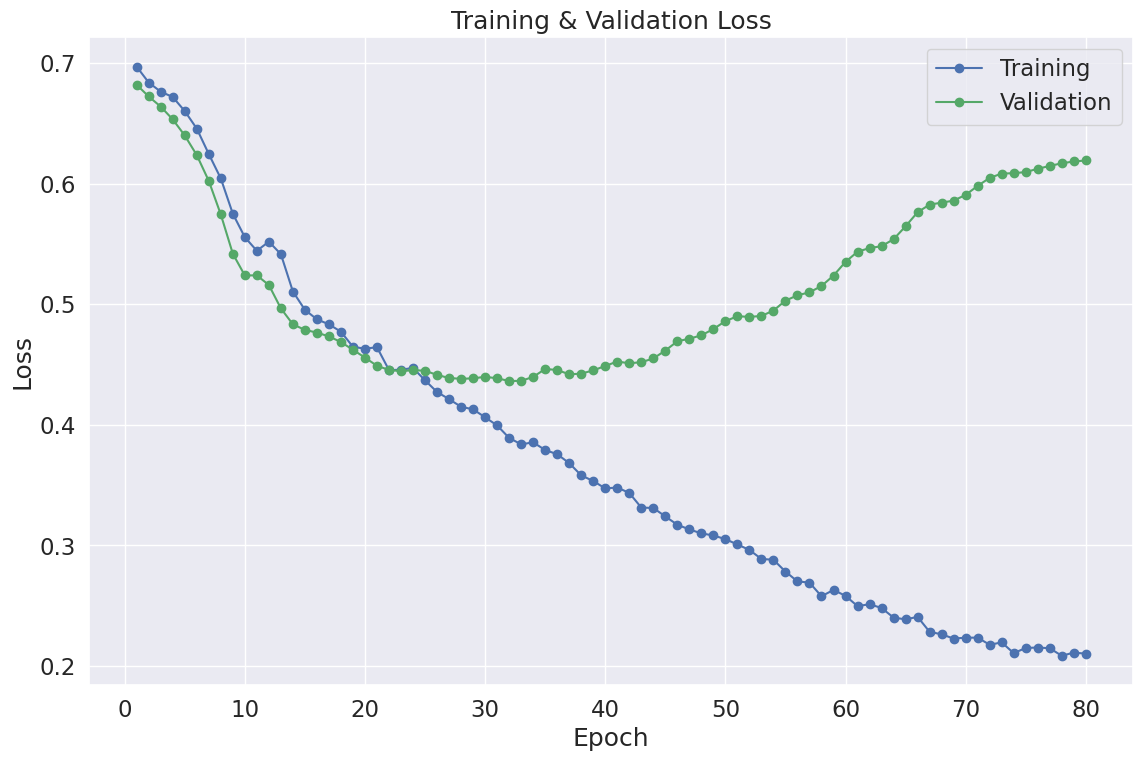

In [47]:
# Increase the plot size and font size:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

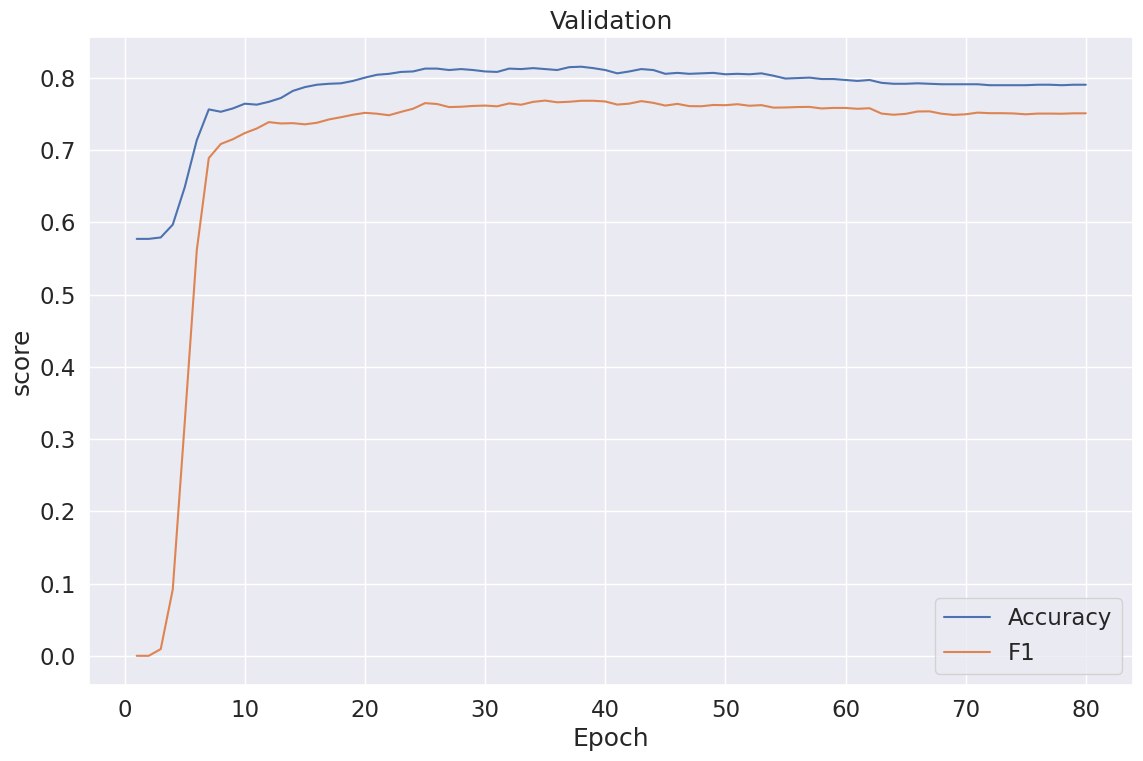

In [48]:
# Increase the plot size and font size:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:
plt.plot(df_stats['Valid. Accur.'], label='Accuracy')
plt.plot(df_stats['Val_F1'], label='F1')

# Label the plot:
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('score')
plt.legend()
plt.show()

# <a id="5"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Results and Analysis </p>   </span></font></center>
# 5. Results and Analysis

Before predict the test data, we need to tuning the hyperparameter of the LSTM model, such as `hidden_size`, `dropout`, `is_bidirectional` etc.
First, we pack the training process as a function.

In [49]:
def train_model(lstm_model, total_epochs=50):
    max_val_f1 = 0
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=5e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    for epoch in range(0, total_epochs):
        lstm_model.train()
        for step, batch in enumerate(train_dataloader):
            text, text_lengths = batch.text
            lstm_model.zero_grad()
            logits = lstm_model(text, text_lengths)
            loss = criterion(logits, batch.label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        # Tracking variables:
        total_eval_f1 = 0
        # Evaluate data for one epoch.
        lstm_model.eval()
        for batch in validation_dataloader:
            text, text_lengths = batch.text
            with torch.no_grad():
                logits = lstm_model(text, text_lengths)

            logits = logits.detach().cpu().numpy()
            label_ids = batch.label.detach().cpu().numpy()
            total_eval_f1 += flat_f1(logits, label_ids)

        avg_val_f1 = total_eval_f1 / len(validation_dataloader)

        if avg_val_f1 > max_val_f1:
            max_val_f1 = avg_val_f1
    return max_val_f1

In [50]:
def tuning_num_layers_and_dropout(num_layers_list, dropout_probs, bidirectional=False):
    lstm_f1_scores_all = []
    for n_layers in tqdm(num_layers_list):
        f1_scores = []
        for dropout in dropout_probs:
            lstm_model = DisasterLSTM(INPUT_DIM,
                                 EMBEDDING_DIM,
                                 HIDDEN_DIM,
                                 OUTPUT_DIM,
                                 n_layers,
                                 bidirectional,
                                 dropout,
                                 PAD_IDX)
            lstm_model.to(device)
            lstm_model.embedding.weight.data.copy_(pretrained_embeddings)
            lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
            f1_scores.append(train_model(lstm_model))
            del lstm_model
        lstm_f1_scores_all.append(f1_scores)
    return lstm_f1_scores_all


In [51]:
num_layers_list = [1, 2, 3]
dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5]

In [52]:
lstm_f1_scores = tuning_num_layers_and_dropout(num_layers_list, dropout_probs)

100%|██████████| 3/3 [02:41<00:00, 53.70s/it]


In [53]:
lstm_f1_scores = pd.DataFrame(lstm_f1_scores, index=num_layers_list, columns=dropout_probs)
lstm_f1_scores

,0.1,0.2,0.3,0.4,0.5
1,0.767987,0.765133,0.768735,0.769848,0.770867
2,0.766096,0.768735,0.765036,0.767757,0.769231
3,0.765232,0.766966,0.765133,0.766169,0.765472


In [54]:
bilstm_f1_scores = tuning_num_layers_and_dropout(num_layers_list, dropout_probs, bidirectional=True)

100%|██████████| 3/3 [05:21<00:00, 107.04s/it]


In [55]:
bilstm_f1_scores = pd.DataFrame(bilstm_f1_scores, index=num_layers_list, columns=dropout_probs)
bilstm_f1_scores

,0.1,0.2,0.3,0.4,0.5
1,0.762288,0.773204,0.765751,0.772581,0.769107
2,0.769600,0.767628,0.770096,0.774297,0.772152
3,0.773312,0.773630,0.771065,0.780564,0.772478


In [56]:
best_params = np.unravel_index(np.argmax(bilstm_f1_scores.values), bilstm_f1_scores.shape)
best_num_layers = num_layers_list[best_params[0]]
best_dropout = dropout_probs[best_params[1]]
best_num_layers, best_dropout

(3, 0.4)

From the experimental results it can be seen that the Bi-LSTM model has the best performance on the validation set when the parameter `num_layers` = 3, `dropout` = 0.4 and increasing `num_layers` results in a more significant improvement in the performance of the Bi-LSTM model compared to the LSTM model.

### Tuning Hyperparameter `hidden_dim`

In [57]:
def tuning_hidden_dim(hidden_dim_list):
    lstm_f1_scores = []
    for hidden_dim in tqdm(hidden_dim_list):
        lstm_model = DisasterLSTM(INPUT_DIM,
                             EMBEDDING_DIM,
                             hidden_dim,
                             OUTPUT_DIM,
                             best_num_layers,
                             True,
                             best_dropout,
                             PAD_IDX)
        lstm_model.to(device)
        lstm_model.embedding.weight.data.copy_(pretrained_embeddings)
        lstm_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
        lstm_f1_scores.append(train_model(lstm_model))
        del lstm_model

    return lstm_f1_scores

In [58]:
hidden_dim_list = [64, 128, 256, 512]
hidden_dim_f1_scores = tuning_hidden_dim(hidden_dim_list)
hidden_dim_f1_scores

100%|██████████| 4/4 [02:37<00:00, 39.44s/it]


[0.768621236133122, 0.7763578274760383, 0.7736298649722002, 0.7688641779189833]

In [59]:
best_hidden_dim = hidden_dim_list[np.array(hidden_dim_f1_scores).argmax()]
best_hidden_dim

128

In [60]:
#creating instance of our LSTM_net class
model = DisasterLSTM(INPUT_DIM,
                     EMBEDDING_DIM,
                     best_hidden_dim,
                     OUTPUT_DIM,
                     best_num_layers,
                     True,
                     best_dropout,
                     PAD_IDX)
model.to(device)  #CNN to GPU
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

training_stats = []
total_t0 = time.time()
max_val_f1 = 0
for epoch_i in range(0, epochs):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        text, text_lengths = batch.text
        model.zero_grad()

        logits = model(text, text_lengths)
        loss = criterion(logits, batch.label)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))
    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()

    # Tracking variables:
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    # Evaluate data for one epoch.
    for batch in validation_dataloader:
        text, text_lengths = batch.text
        with torch.no_grad():
            logits = model(text, text_lengths)
            loss = criterion(logits, batch.label)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = batch.label.detach().cpu().numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    if avg_val_f1 > max_val_f1:
        max_val_f1 = avg_val_f1
        torch.save(model.state_dict(), 'checkpoints/lstm/model.pth')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')


======== Epoch 1 / 80 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.56
  F1: 0.02
  Validation Loss: 0.69
  Validation took: 0:00:00

======== Epoch 2 / 80 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validation Loss: 0.68
  Validation took: 0:00:00

======== Epoch 3 / 80 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validation Loss: 0.68
  Validation took: 0:00:00

======== Epoch 4 / 80 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validation Loss: 0.67
  Validation took: 0:00:00

======== Epoch 5 / 80 ========
Training...

  Average training loss: 0.68
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.58
  F1: 0.00
  Validatio

In [62]:
# Prediction on test set:
print('Predicting labels for {:,} test sentences...'.format(len(test_df)))
model.load_state_dict(torch.load('checkpoints/lstm/model.pth'))
model.eval()
predictions = []
for batch in tqdm(test_dataloader):
    text, text_lengths = batch.text
    with torch.no_grad():
        logits = model(text, text_lengths)
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
print('    DONE.')

Predicting labels for 3,263 test sentences...


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]

    DONE.


In [63]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [64]:
# Creating submission data.
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [65]:
# Saving submission to '.csv' file:
submission.to_csv('data/submission_lstm.csv', index=False, header=True)

We tried two model architectures, LSTM and Bi-LSTM, respectively, and adjusted the hyperparameters such as the number of layers, the dimension of the hidden layer, and the size of the dropout of LSTM, respectively, and obtained the following conclusions.
- Whether it is LSTM or Bi-LSTM, increasing the size of the model will achieve some improvement in performance.
- All the models in the experiment have serious overfitting, when the dropout is set small, the overfitting is more serious, and when the dropout is set large, the model cannot be trained properly, so we need to choose the appropriate dropout.
- In addition, the hidden layer dimension is also a very important hyperparameter, too large or too small hidden layer dimension will affect the final performance of the model.


# <a id="6"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Conclusion </p>   </span></font></center>
# 6. Conclusion

- In general, the higher the performance of the model, the better the fit, but more prone to overfitting, which can be mitigated by methods such as early_stop and dropout.
- Here we use GLoVe for word embedding, which is usually better than the tf-idf method.
- In NLP tasks it is necessary to clean the text, including but not limited to word splitting, deduplication, tokenisation, etc.
- In data mining tasks, data cleaning and exploratory data analysis are two very important components.
- Models such as RNN, GRU, etc. can also be used for training to compare their performance with LSTM models.
- Finally, we used the more advanced BERT model to predict the categories of the text. The results show that the performance of BERT, pre-trained on a large corpus and fine-tuned to the downstream task, significantly outperforms the LSTM model.

# <a id="7"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">Extra</p>   </span></font></center>

## BERT
The BERT model was proposed in BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. It’s a bidirectional transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

In [66]:
# Tokenizing the combined text data using bert tokenizer.
tokenizer = BertTokenizer.from_pretrained('checkpoints/bert-large-uncased', local_files_only=True)

In [67]:
# Print the original tweet.
print(' Original: ', train[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(train[0]))

# Print the sentence mapped to token ID's.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train[0])))

 Original:  deed reason earthquake may allah forgive u
Tokenized:  ['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']
Token IDs:  [15046, 3114, 8372, 2089, 16455, 9641, 1057]


In [68]:
max_len = 0

for text in train:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

for text in test:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  55


In [69]:
def tokenize_map(sentence, labs=None):
    global labels
    input_ids = []
    attention_masks = []

    for text in sentence:
        #   "encode_plus" will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = max_len,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs is not None: # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [70]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.
input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks = tokenize_map(test)

In [71]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
train_size = 0.8
val_size = 1 - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

6,091 training samples
1,522 validation samples


In [72]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [73]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset,
                                   sampler=SequentialSampler(test_dataset),
                                   batch_size=batch_size)

In [74]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    'checkpoints/bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    local_files_only=True
)

# Tell pytorch to run this model on the device which we set GPU in our case.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at checkpoints/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [75]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [76]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = 10
# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [77]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat)

In [78]:
training_stats = []
total_t0 = time.time()
max_val_acc = 0
for epoch_i in range(0, epochs):
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        model.zero_grad()
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)[:]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()

    # Tracking variables:
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    # Evaluate data for one epoch.
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            loss, logits = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[:]
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    if avg_val_accuracy > max_val_acc:
        max_val_acc = avg_val_accuracy
        torch.save(model.state_dict(), 'checkpoints/bert-large-uncased/model.pth')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:45.
  Batch   100  of    191.    Elapsed: 0:01:30.
  Batch   150  of    191.    Elapsed: 0:02:15.

  Average training loss: 0.52
  Training epcoh took: 0:02:51

Running Validation...
  Accuracy: 0.82
  F1: 0.77
  Validation Loss: 0.44
  Validation took: 0:00:14

======== Epoch 2 / 10 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:45.
  Batch   100  of    191.    Elapsed: 0:01:30.
  Batch   150  of    191.    Elapsed: 0:02:15.

  Average training loss: 0.41
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.82
  F1: 0.79
  Validation Loss: 0.44
  Validation took: 0:00:14

======== Epoch 3 / 10 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:45.
  Batch   100  of    191.    Elapsed: 0:01:30.
  Batch   150  of    191.    Elapsed: 0:02:15.

  Average training loss: 0.35
  Training epcoh took: 0:02:52

Running Validation...
  Accuracy: 0.84
  F1: 0.80
  Va

In [79]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# Display the table.
display(df_stats)

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.516405,0.436111,0.815755,0.772474,0:02:51,0:00:14
2,0.412537,0.436351,0.822266,0.785848,0:02:52,0:00:14
3,0.352545,0.411803,0.840495,0.797126,0:02:52,0:00:14
4,0.309218,0.449392,0.817057,0.781596,0:02:52,0:00:14
5,0.261281,0.479784,0.817057,0.778059,0:02:53,0:00:14
6,0.224259,0.497610,0.818504,0.773710,0:02:53,0:00:14
7,0.205685,0.549476,0.818359,0.778726,0:02:52,0:00:14
8,0.181165,0.562852,0.819155,0.778754,0:02:52,0:00:14
9,0.162798,0.593334,0.815249,0.775144,0:02:52,0:00:14


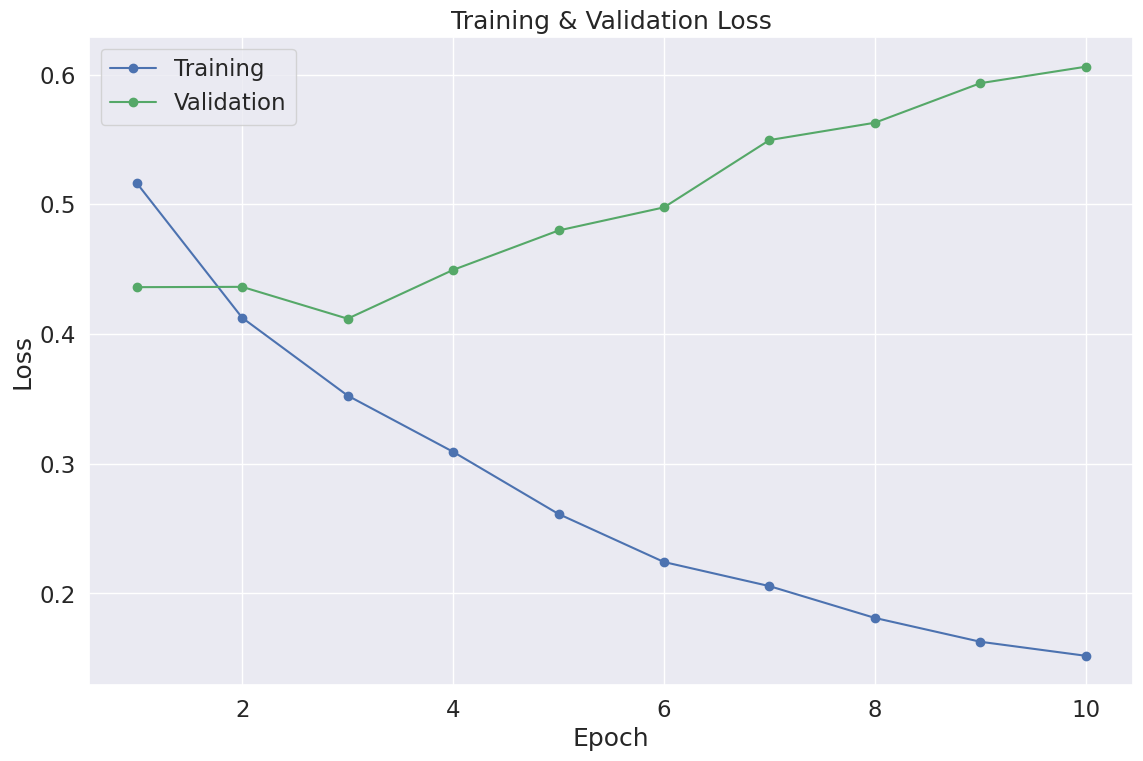

In [80]:
# Increase the plot size and font size:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

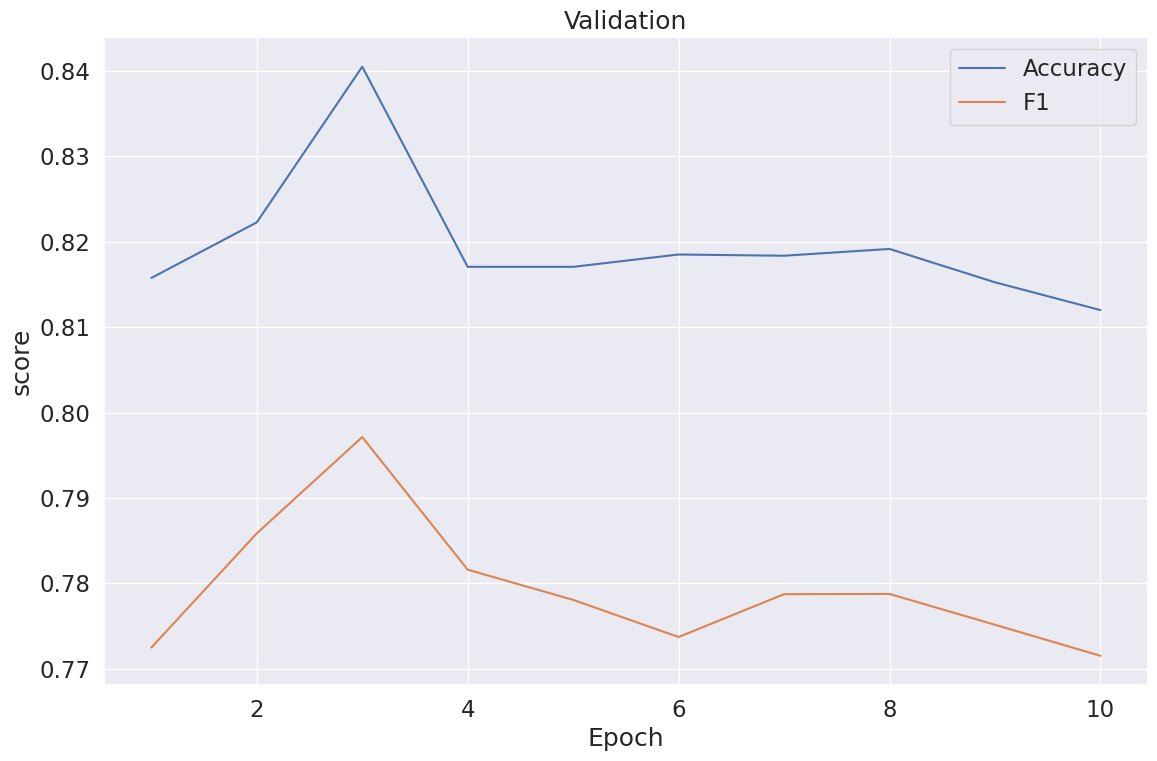

In [81]:
# Increase the plot size and font size:
fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:
plt.plot(df_stats['Valid. Accur.'], label='Accuracy')
plt.plot(df_stats['Val_F1'], label='F1')

# Label the plot:
plt.title('Validation')
plt.xlabel('Epoch')
plt.ylabel('score')
plt.legend()
plt.show()

In [82]:
# Prediction on test set:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
model.load_state_dict(torch.load('checkpoints/bert-large-uncased/model.pth'))
model.eval()
predictions = []
for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, = batch
    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
print('    DONE.')

Predicting labels for 3,263 test sentences...


100%|██████████| 102/102 [00:30<00:00,  3.34it/s]

    DONE.


In [83]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [84]:
# Creating submission data.
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [85]:
# Saving submission to '.csv' file:
submission.to_csv('data/submission_bert.csv', index=False, header=True)
